In [1]:
import pandas as pd
import numpy as np
import warnings
import sys
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys

sys.path.append("..")
# sys.path.append(".")
from tool import market_dynamics_modeling_analysis
from tool import label_util as util
from comprehensive_evaluation.analyzer import *
from comprehensive_evaluation.util import *
from comprehensive_evaluation.slice_model import *

In [2]:
positions = np.load("../data/micro_action.npy")
data = pd.read_feather("../data/test.feather")
strategy = transform_market_order_strategy(data, positions, max_holding_number=4000)

In [3]:
data.tail()

,timestamp,symbol,ask1_price,ask1_size,bid1_price,bid1_size,ask2_price,ask2_size,bid2_price,bid2_size,...,roc_60_m,beta_60_m,max_60_m,min_60_m,qtlu_60_m,qtld_60_m,imax_60_m,imin_60_m,imxd_60_m,imxd_60_dis_m
794143,2022-08-15 23:59:55,GALAUSDT,0.06704,21530.0,0.06703,28875.0,0.06705,5965.0,0.06702,162802.0,...,-0.970452,-0.016174,0.369696,-2.726508,0.009242,-2.19507,0.916667,0.083333,0.833333,1.0
794144,2022-08-15 23:59:56,GALAUSDT,0.06704,21530.0,0.06703,28875.0,0.06705,5965.0,0.06702,167709.0,...,-0.970452,-0.016174,0.369696,-2.726508,0.009242,-2.19507,0.916667,0.083333,0.833333,1.0
794145,2022-08-15 23:59:57,GALAUSDT,0.06704,21530.0,0.06703,28875.0,0.06705,5965.0,0.06702,302709.0,...,-0.970452,-0.016174,0.369696,-2.726508,0.009242,-2.19507,0.916667,0.083333,0.833333,1.0
794146,2022-08-15 23:59:58,GALAUSDT,0.06704,21424.0,0.06703,33631.0,0.06705,5965.0,0.06702,174304.0,...,-0.970452,-0.016174,0.369696,-2.726508,0.009242,-2.19507,0.916667,0.083333,0.833333,1.0
794147,2022-08-15 23:59:59,GALAUSDT,0.06708,7501.0,0.06707,10093.0,0.06709,442.0,0.06706,16767.0,...,-0.970452,-0.016174,0.369696,-2.726508,0.009242,-2.19507,0.916667,0.083333,0.833333,1.0


In [4]:
strategy

[{'timestamp': Timestamp('2022-08-06 21:26:56'),
  'action': 'buy',
  'order': [{'price': 0.06047, 'amount': 1735.0},
   {'price': 0.06048, 'amount': 2265.0}],
  'position': 4000.0},
 {'timestamp': Timestamp('2022-08-07 01:39:19'),
  'action': 'sell',
  'order': [{'price': 0.05948, 'amount': 4000.0}],
  'position': 0.0},
 {'timestamp': Timestamp('2022-08-07 01:53:25'),
  'action': 'buy',
  'order': [{'price': 0.05954, 'amount': 2000.0}],
  'position': 2000.0},
 {'timestamp': Timestamp('2022-08-07 01:54:24'),
  'action': 'sell',
  'order': [{'price': 0.05954, 'amount': 1000.0}],
  'position': 1000.0},
 {'timestamp': Timestamp('2022-08-07 01:55:11'),
  'action': 'sell',
  'order': [{'price': 0.05952, 'amount': 1000.0}],
  'position': 0.0},
 {'timestamp': Timestamp('2022-08-07 02:01:36'),
  'action': 'buy',
  'order': [{'price': 0.05953, 'amount': 1000.0}],
  'position': 1000.0},
 {'timestamp': Timestamp('2022-08-07 02:01:58'),
  'action': 'buy',
  'order': [{'price': 0.0595, 'amount': 10

### Analyzer

In [5]:
def calculate_metric(selected_timestamp: list):
    # selected trade is part of the strategy that we want to calculate the metric,
    # its position but do not have to end or start with 0
    # selected_timestamp is a 2-element list indicating the start and end of the timestamp
    selected_timestamp.sort()
    assert len(selected_timestamp) == 2
    selected_market = data[  # 所有market time
        (data["timestamp"] >= selected_timestamp[0])
        & (data["timestamp"] <= selected_timestamp[1])
    ]
    selected_strategy = [  # 进行交易的market time
        item
        for item in strategy
        if selected_timestamp[0] <= item["timestamp"] <= selected_timestamp[1]
    ]

    first_trade = selected_strategy[0]
    first_trade_size = sum([level["amount"] for level in first_trade["order"]])
    if first_trade["action"] == "buy":
        first_trade_size = -first_trade_size
    initial_posotion = (
        selected_strategy[0]["position"] + first_trade_size
    )  # 第一次交易发生前的position
    assert initial_posotion >= 0

    cash_flow = []
    for stack_order in selected_strategy:
        total_value = 0
        for order in stack_order["order"]:
            total_value += order["price"] * order["amount"]
            if stack_order["action"] == "buy":
                total_value = -total_value
            cash_flow.append(total_value)
    initial_require_money = initial_posotion * selected_market["bid1_price"].values[0]
    cash_record = [sum(cash_flow[: i + 1]) for i in range(len(cash_flow))]
    require_money = initial_require_money - min(
        0, min(cash_record)
    )  # MIN(0,min cash ): 如果买入太多现金变负数了，需要补； 一直正的话就不需要加初始金
    position = initial_posotion
    position_market_record = []
    cash_market_record = []
    for timestamp in selected_market.timestamp.unique():
        matching_strategy = next(
            (item for item in selected_strategy if item["timestamp"] == timestamp),
            None,
        )
        if matching_strategy:  # 这个时间进行交易的话，更新position
            current_position = matching_strategy["position"]
            position = current_position
        else:  # 没有进行交易，保持上一个时间的position
            current_position = position
        position_market_record.append(current_position)
    inital_cash = require_money - initial_require_money
    cash = inital_cash
    for timestamp in selected_market.timestamp.unique():
        matching_strategy = next(
            (item for item in selected_strategy if item["timestamp"] == timestamp),
            None,
        )
        if matching_strategy:
            total_value = 0
            for order in matching_strategy["order"]:
                total_value += order["price"] * order["amount"]
                if stack_order["action"] == "buy":
                    total_value = -total_value
            current_cash = cash + total_value
            cash = current_cash
        else:
            current_cash = cash
        cash_market_record.append(current_cash)
    assert len(position_market_record) == len(selected_market)
    selected_market_price = selected_market["bid1_price"].values
    position_value_record = [
        position * single_value
        for position, single_value in zip(position_market_record, selected_market_price)
    ]
    total_value_record = [
        cash + position_value
        for cash, position_value in zip(cash_market_record, position_value_record)
    ]
    tr = total_value_record[-1] / total_value_record[0] - 1
    mdd = 0
    peak = total_value_record[0]
    for value in total_value_record:
        if value > peak:
            peak = value
        dd = (peak - value) / peak
        if dd > mdd:
            mdd = dd
    cr = tr / mdd
    return tr, mdd, cr

labeling start
../data/test4/valid_processed.feather
start fitting
Only merge dynamic <= distance:  1
merging round:  1 current number of segments:  7986


  0%|          | 0/7986 [00:00<?, ?it/s]/home/mlqin/anaconda3/envs/HFT/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mlqin/anaconda3/envs/HFT/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 7986/7986 [00:13<00:00, 588.93it/s]


All distance statistics:
count    15792.000000
mean         0.001078
std          0.000988
min          0.000008
25%          0.000481
50%          0.000797
75%          0.001348
max          0.018545
dtype: float64
Your merging_threshold is:  0.0003
Merge prohibit times by merging_dynamic_constraint: 336
merging round:  2 current number of segments:  6915


  0%|          | 0/7986 [00:00<?, ?it/s]/home/mlqin/anaconda3/envs/HFT/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mlqin/anaconda3/envs/HFT/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 7986/7986 [00:14<00:00, 551.87it/s]


All distance statistics:
count    13677.000000
mean         0.001176
std          0.001009
min          0.000100
25%          0.000565
50%          0.000877
75%          0.001461
max          0.018570
dtype: float64
Your merging_threshold is:  0.0003
Merge prohibit times by merging_dynamic_constraint: 156
merging round:  3 current number of segments:  6823


  0%|          | 0/7986 [00:00<?, ?it/s]/home/mlqin/anaconda3/envs/HFT/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mlqin/anaconda3/envs/HFT/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 7986/7986 [00:16<00:00, 483.81it/s]


All distance statistics:
count    13492.000000
mean         0.001185
std          0.001011
min          0.000163
25%          0.000571
50%          0.000882
75%          0.001472
max          0.018552
dtype: float64
Your merging_threshold is:  0.0003
Merge prohibit times by merging_dynamic_constraint: 144
merging round:  4 current number of segments:  6815


  0%|          | 0/7986 [00:00<?, ?it/s]/home/mlqin/anaconda3/envs/HFT/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mlqin/anaconda3/envs/HFT/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 7986/7986 [00:18<00:00, 436.66it/s]


All distance statistics:
count    13476.000000
mean         0.001186
std          0.001012
min          0.000169
25%          0.000572
50%          0.000885
75%          0.001474
max          0.018673
dtype: float64
Your merging_threshold is:  0.0003
Merge prohibit times by merging_dynamic_constraint: 144
merging round:  5 current number of segments:  6812


  0%|          | 0/7986 [00:00<?, ?it/s]/home/mlqin/anaconda3/envs/HFT/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mlqin/anaconda3/envs/HFT/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 7986/7986 [00:20<00:00, 396.66it/s]


All distance statistics:
count    13470.000000
mean         0.001186
std          0.001011
min          0.000170
25%          0.000572
50%          0.000885
75%          0.001473
max          0.018635
dtype: float64
Your merging_threshold is:  0.0003
Merge prohibit times by merging_dynamic_constraint: 144
merging_round in total: 5, number of segments: 6813
You may want to tune the merging_threshold and merging_dynamic_constraint to get a better result.
finish fitting
finish labeling
labeling done
start save whole file !!!!!!!!!!!!!!!!!!!!!!!!
saving done !!!!!!!!!!!!!!!!!!!!!!!!

in the 0th segment, the total return rate is 11.231567998349286, the max drawdown is 0.015818413614059855, the calmar ratio is 710.0312504388145


in the 1th segment, the total return rate is 34.75158238495639, the max drawdown is 0.004469174431128933, the calmar ratio is 7775.839345831483


in the 2th segment, the total return rate is 31.16418874183622, the max drawdown is 0.0036074014498507674, the calmar ra

/tmp/ipykernel_3441975/1716008917.py:177: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


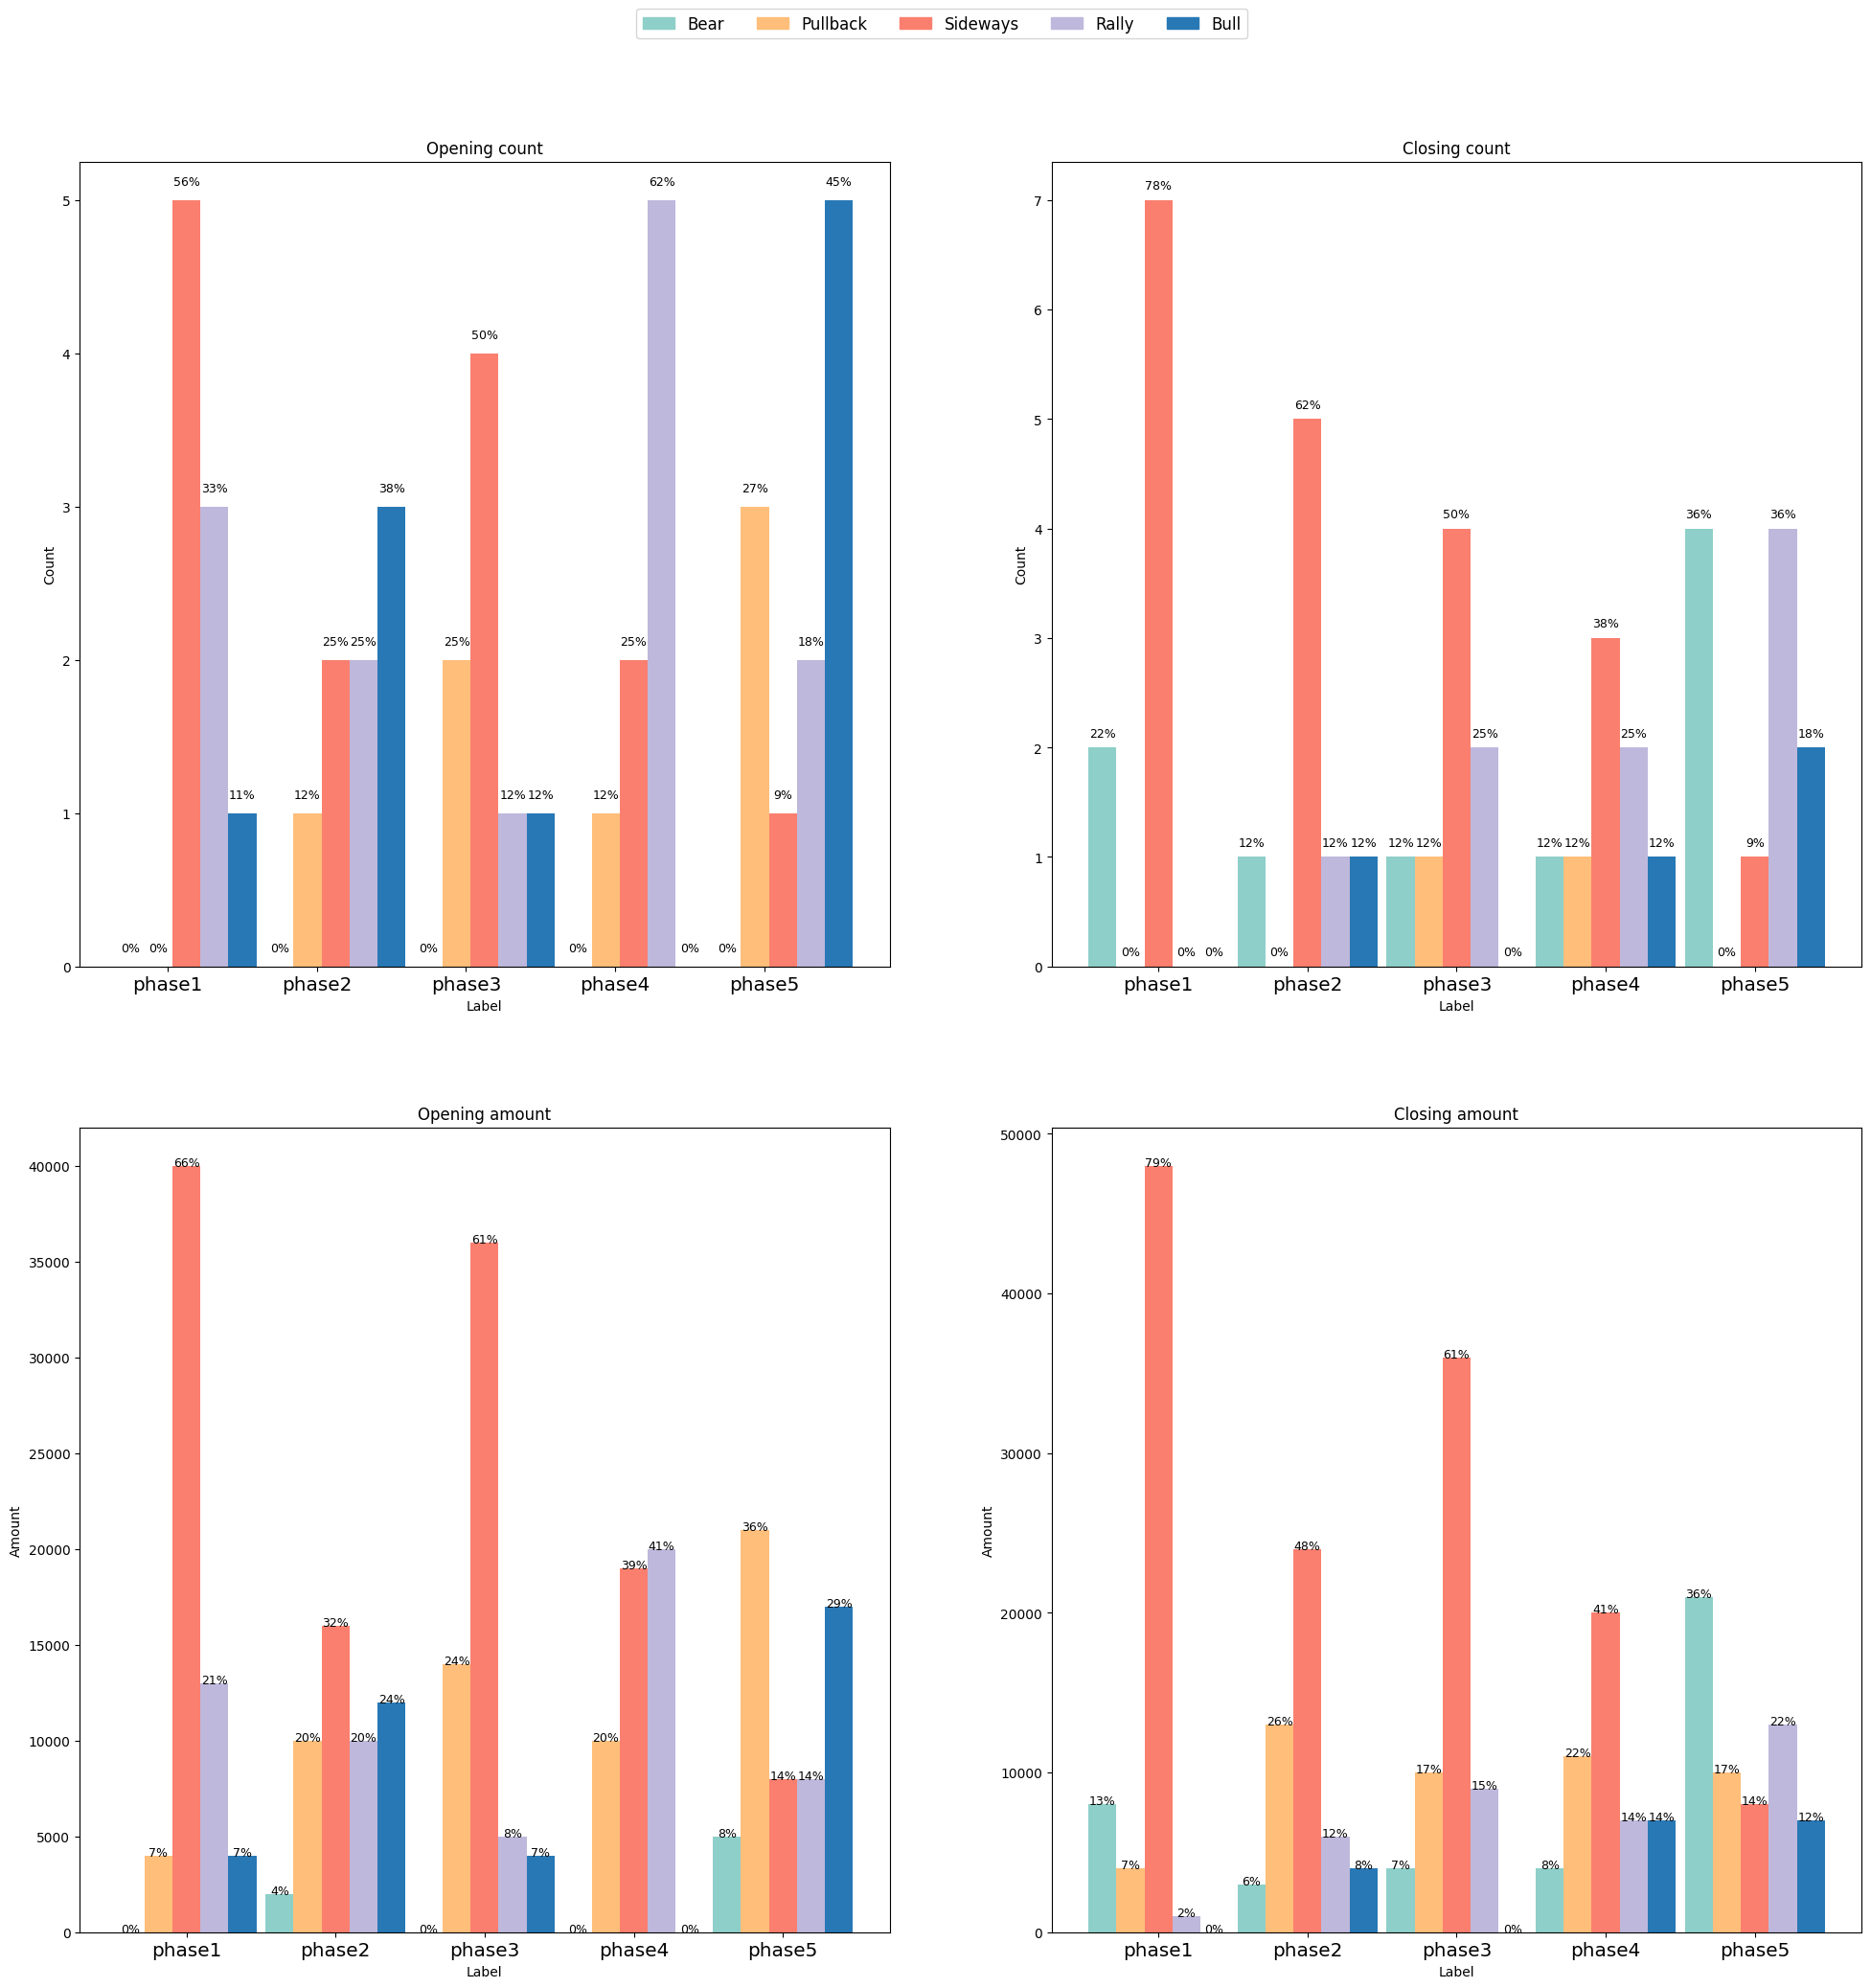

opening_count_seg [[0, 0, 5, 3, 1], [0, 1, 2, 2, 3], [0, 2, 4, 1, 1], [0, 1, 2, 5, 0], [0, 3, 1, 2, 5]]
closing_count_seg [[2, 0, 7, 0, 0], [1, 0, 5, 1, 1], [1, 1, 4, 2, 0], [1, 1, 3, 2, 1], [4, 0, 1, 4, 2]]
opening_amount_seg [[0, 4000.0, 40000.0, 13000.0, 4000.0], [2000.0, 10000.0, 16000.0, 10000.0, 12000.0], [0, 14000.0, 36000.0, 5000.0, 4000.0], [0, 10000.0, 19000.0, 20000.0, 0], [5000.0, 21000.0, 8000.0, 8000.0, 17000.0]]
closing_amount_seg [[8000.0, 4000.0, 48000.0, 1000.0, 0], [3000.0, 13000.0, 24000.0, 6000.0, 4000.0], [4000.0, 10000.0, 36000.0, 9000.0, 0], [4000.0, 11000.0, 20000.0, 7000.0, 7000.0], [21000.0, 10000.0, 8000.0, 13000.0, 7000.0]]


In [6]:
def analysis_along_time_dynamics(path, num_dynamics, num_seg, selected_timestamp: list):
    # TODO 给定段时间，先把这段时间内的市场状态划分成num_dynamics个市场状态
    # TODO 根据策略 用开平仓的次数来划分时间（总开平仓次数）
    # TODO 两维度从时间和市场状态 计算胜率，收益率，持仓时间，最大回撤，calmar ratio，已经开仓量和平仓量占总开仓量和平仓量的百分比

    selected_market = data[
        (data["timestamp"] >= selected_timestamp[0])
        & (data["timestamp"] <= selected_timestamp[1])
    ]

    model = Linear_Market_Dynamics_Model(
        data=selected_market.reset_index(), dynamic_number=num_dynamics
    )
    model.run(path)
    df_label = pd.read_feather(path + "/df_label.feather")
    assert len(selected_market) == len(df_label)

    opening_count_seg = [[0] * num_dynamics] * num_seg
    closing_count_seg = [[0] * num_dynamics] * num_seg
    opening_amount_seg = [[0] * num_dynamics] * num_seg
    closing_amount_seg = [[0] * num_dynamics] * num_seg

    opening_strategy_timestamp_list = []
    closing_strategy_timestamp_list = []

    for stack_order in strategy:  # self.
        if stack_order["action"] == "buy":
            order_size = 0
            for order in stack_order["order"]:
                order_size += order["amount"]
            if order_size == stack_order["position"]:
                opening_strategy_timestamp_list.append(stack_order["timestamp"])
        elif stack_order["action"] == "sell":
            if stack_order["position"] == 0:
                closing_strategy_timestamp_list.append(stack_order["timestamp"])
    assert len(opening_strategy_timestamp_list) == len(closing_strategy_timestamp_list)
    # print(len(opening_strategy_timestamp_list))
    assert len(opening_strategy_timestamp_list) >= num_seg
    num_trade_seg = int(len(opening_strategy_timestamp_list) / num_seg)

    def calculate(local_selected_timestamp):
        tr, mdd, cr = calculate_metric(
            local_selected_timestamp
        )  # self.calculate_metric
        print()
        print(
            "in the {}th segment, the total return rate is {}, the max drawdown is {}, the calmar ratio is {}".format(
                i, tr, mdd, cr
            )
        )
        print()

    def along_dynamics(local_selected_timestamp, index_seg):
        selected_market = data[
            (data["timestamp"] >= local_selected_timestamp[0])
            & (data["timestamp"] <= local_selected_timestamp[1])
        ]
        selected_strategy = [  # 进行交易的market time
            item
            for item in strategy
            if local_selected_timestamp[0]
            <= item["timestamp"]
            <= local_selected_timestamp[1]
        ]

        opening_strategy_timestamp_list = []
        closing_strategy_timestamp_list = []
        opening_count = [0] * 5
        closing_count = [0] * 5
        opening_amount = [0] * 5
        closing_amount = [0] * 5

        for stack_order in selected_strategy:
            # print(stack_order)
            if stack_order["action"] == "buy":
                order_size = 0
                for order in stack_order["order"]:
                    order_size += order["amount"]
                label_index = df_label[
                    df_label["timestamp"] == stack_order["timestamp"]
                ]["label"].values[
                    0
                ]  # 获取label
                opening_amount[label_index] += sum(
                    level["amount"] for level in stack_order["order"]
                )  # 记录开仓总量至对应label
                if order_size == stack_order["position"]:
                    # print(stack_order["timestamp"])
                    opening_strategy_timestamp_list.append(stack_order["timestamp"])
                    opening_count[label_index] += 1  # 记录对应label的开仓次数
                    # print("add buy count {} for label {}".format(opening_count[label_index], label_index))
                # sumtemp = sum( level['amount'] for level in stack_order['order'])
                # print("add buy amount {} for label {}".format(sumtemp, label_index))

            elif stack_order["action"] == "sell":
                label_index = df_label[
                    df_label["timestamp"] == stack_order["timestamp"]
                ]["label"].values[0]
                closing_amount[label_index] += sum(
                    level["amount"] for level in stack_order["order"]
                )
                if stack_order["position"] == 0:
                    # print(stack_order["timestamp"])
                    closing_strategy_timestamp_list.append(stack_order["timestamp"])
                    closing_count[label_index] += 1
                    # print("add sell count {} for label {}".format(closing_count[label_index], label_index))
                # sumtemp = sum( level['amount'] for level in stack_order['order'])
                # print("add sell record {} for label {}".format(sumtemp, label_index))

        opening_count_seg[index_seg] = opening_count
        closing_count_seg[index_seg] = closing_count
        opening_amount_seg[index_seg] = opening_amount
        closing_amount_seg[index_seg] = closing_amount

    for i in range(num_seg):
        # print()
        # print("this is segment {}".format(i))
        start_market_time = 0
        if i == 0:
            start_market_time = opening_strategy_timestamp_list[num_trade_seg * 0]
        else:
            for row_index, row in data.iterrows():
                if (
                    row["timestamp"]
                    > closing_strategy_timestamp_list[num_trade_seg * i]
                ):
                    start_market_time = row["timestamp"]
                    break

        if i == num_seg - 1:
            close_market_time = closing_strategy_timestamp_list[-1]
        else:
            close_market_time = closing_strategy_timestamp_list[num_trade_seg * (i + 1)]

        phase_selected_timestamp = [start_market_time, close_market_time]
        calculate(phase_selected_timestamp)
        along_dynamics(phase_selected_timestamp, i)

    opening_count_perc = [
        [float(format(x / sum(opening_count), ".2f")) for x in opening_count]
        for opening_count in opening_count_seg
    ]
    closing_count_perc = [
        [float(format(x / sum(closing_count), ".2f")) for x in closing_count]
        for closing_count in closing_count_seg
    ]
    opening_amount_perc = [
        [float(format(x / sum(opening_amount), ".2f")) for x in opening_amount]
        for opening_amount in opening_amount_seg
    ]
    closing_amount_perc = [
        [float(format(x / sum(closing_amount), ".2f")) for x in closing_amount]
        for closing_amount in closing_amount_seg
    ]

    color_list = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#BEB8DC", "#2878B5"]
    x_label = ["phase1","phase2","phase3","phase4","phase5"]
    y_label = ["Bull", "Rally", "Sideways", "Pullback", "Bear"]
    y_label.reverse()


    x_ax = np.array(range(len(x_label)))*4

    fig = plt.figure(figsize=(24,24))
    # plt.suptitle('Opening/Closing counts/amounts along different time with diff market type')

    patches = [
        mpatches.Patch(color=color_list[i], label="{:s}".format(y_label[i]))
        for i in range(len(color_list))
    ]

    ax = plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width , box.height* 0.75])
    fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=5, fontsize='large')

    plt.subplot(221)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Opening count')
    for i in range(5):
        plt.bar(
            [m + i * 0.75 for m in x_ax],
            [count[i] for count in opening_count_seg],
            label=y_label[i],
            width=0.75,
            color=color_list[i],
        )
    plt.xticks([i + 1 for i in x_ax], x_label, fontsize="x-large")
    for i in range(len(opening_count_seg)):
        plotdata=[count[i] for count in opening_count_seg]
        for x,y in enumerate(plotdata):
            plt.text(x*4+i*0.75, y+0.1,  format(opening_count_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)

    plt.subplot(222)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Closing count')
    for i in range(5):
        plt.bar(
            [m + i * 0.75 for m in x_ax],
            [count[i] for count in closing_count_seg],
            label=y_label[i],
            width=0.75,
            color=color_list[i],
        )
    plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
    for i in range(len(closing_count_seg)):
        plotdata=[count[i] for count in closing_count_seg]
        for x,y in enumerate(plotdata):
            plt.text(x*4+i*0.75, y+0.1, format(closing_count_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)
            
    plt.subplot(223)
    plt.xlabel('Label')
    plt.ylabel('Amount')
    plt.title('Opening amount')
    for i in range(5):
        plt.bar(
            [m + i * 0.75 for m in x_ax],
            [count[i] for count in opening_amount_seg],
            label=y_label[i],
            width=0.75,
            color=color_list[i],
        )
    plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
    for i in range(len(opening_amount_seg)):
        plotdata=[count[i] for count in opening_amount_seg]
        for x,y in enumerate(plotdata):
            plt.text(x*4+i*0.75, y+0.1, format(opening_amount_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)
            
    plt.subplot(224)
    plt.xlabel('Label')
    plt.ylabel('Amount')
    plt.title('Closing amount')
    for i in range(5):
        plt.bar(
            [m + i * 0.75 for m in x_ax],
            [count[i] for count in closing_amount_seg],
            label=y_label[i],
            width=0.75,
            color=color_list[i],
        )
    plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
    for i in range(len(closing_amount_seg)):
        plotdata=[count[i] for count in closing_amount_seg]
        for x,y in enumerate(plotdata):
            plt.text(x*4+i*0.75, y+0.1, format(closing_amount_perc[x][i]*100,'.0f') + "%"  ,ha='center',fontsize=9)

    img_path = path + "/time_dynamics_proportion.pdf"        
    plt.savefig(img_path,bbox_inches='tight')
    plt.show()

    return opening_count_seg, closing_count_seg, opening_amount_seg, closing_amount_seg


num_seg = 5
selected_timestamp = [
    pd.Timestamp("2022-08-06 19:24:12"),
    pd.Timestamp("2022-08-15 23:59:59"),
]
num_dynamics = 5
path = "../data/test4"
(
    opening_count_seg,
    closing_count_seg,
    opening_amount_seg,
    closing_amount_seg,
) = analysis_along_time_dynamics(path, num_dynamics, num_seg, selected_timestamp)
print("opening_count_seg", opening_count_seg)
print("closing_count_seg", closing_count_seg)
print("opening_amount_seg", opening_amount_seg)
print("closing_amount_seg", closing_amount_seg)

In [13]:
opening_count_perc = [
    [float(format(x / sum(opening_count), ".2f")) for x in opening_count]
    for opening_count in opening_count_seg
]
closing_count_perc = [
    [float(format(x / sum(closing_count), ".2f")) for x in closing_count]
    for closing_count in closing_count_seg
]
opening_amount_perc = [
    [float(format(x / sum(opening_amount), ".2f")) for x in opening_amount]
    for opening_amount in opening_amount_seg
]
closing_amount_perc = [
    [float(format(x / sum(closing_amount), ".2f")) for x in closing_amount]
    for closing_amount in closing_amount_seg
]
print("opening_count_perc", opening_count_perc)
print("closing_count_perc", closing_count_perc)
print("opening_amount_perc", opening_amount_perc)
print("closing_amount_perc", closing_amount_perc)

opening_count_perc [[0.0, 0.0, 0.56, 0.33, 0.11], [0.0, 0.12, 0.25, 0.25, 0.38], [0.0, 0.25, 0.5, 0.12, 0.12], [0.0, 0.12, 0.25, 0.62, 0.0], [0.0, 0.27, 0.09, 0.18, 0.45]]
closing_count_perc [[0.22, 0.0, 0.78, 0.0, 0.0], [0.12, 0.0, 0.62, 0.12, 0.12], [0.12, 0.12, 0.5, 0.25, 0.0], [0.12, 0.12, 0.38, 0.25, 0.12], [0.36, 0.0, 0.09, 0.36, 0.18]]
opening_amount_perc [[0.0, 0.07, 0.66, 0.21, 0.07], [0.04, 0.2, 0.32, 0.2, 0.24], [0.0, 0.24, 0.61, 0.08, 0.07], [0.0, 0.2, 0.39, 0.41, 0.0], [0.08, 0.36, 0.14, 0.14, 0.29]]
closing_amount_perc [[0.13, 0.07, 0.79, 0.02, 0.0], [0.06, 0.26, 0.48, 0.12, 0.08], [0.07, 0.17, 0.61, 0.15, 0.0], [0.08, 0.22, 0.41, 0.14, 0.14], [0.36, 0.17, 0.14, 0.22, 0.12]]


/tmp/ipykernel_2955417/2075802697.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


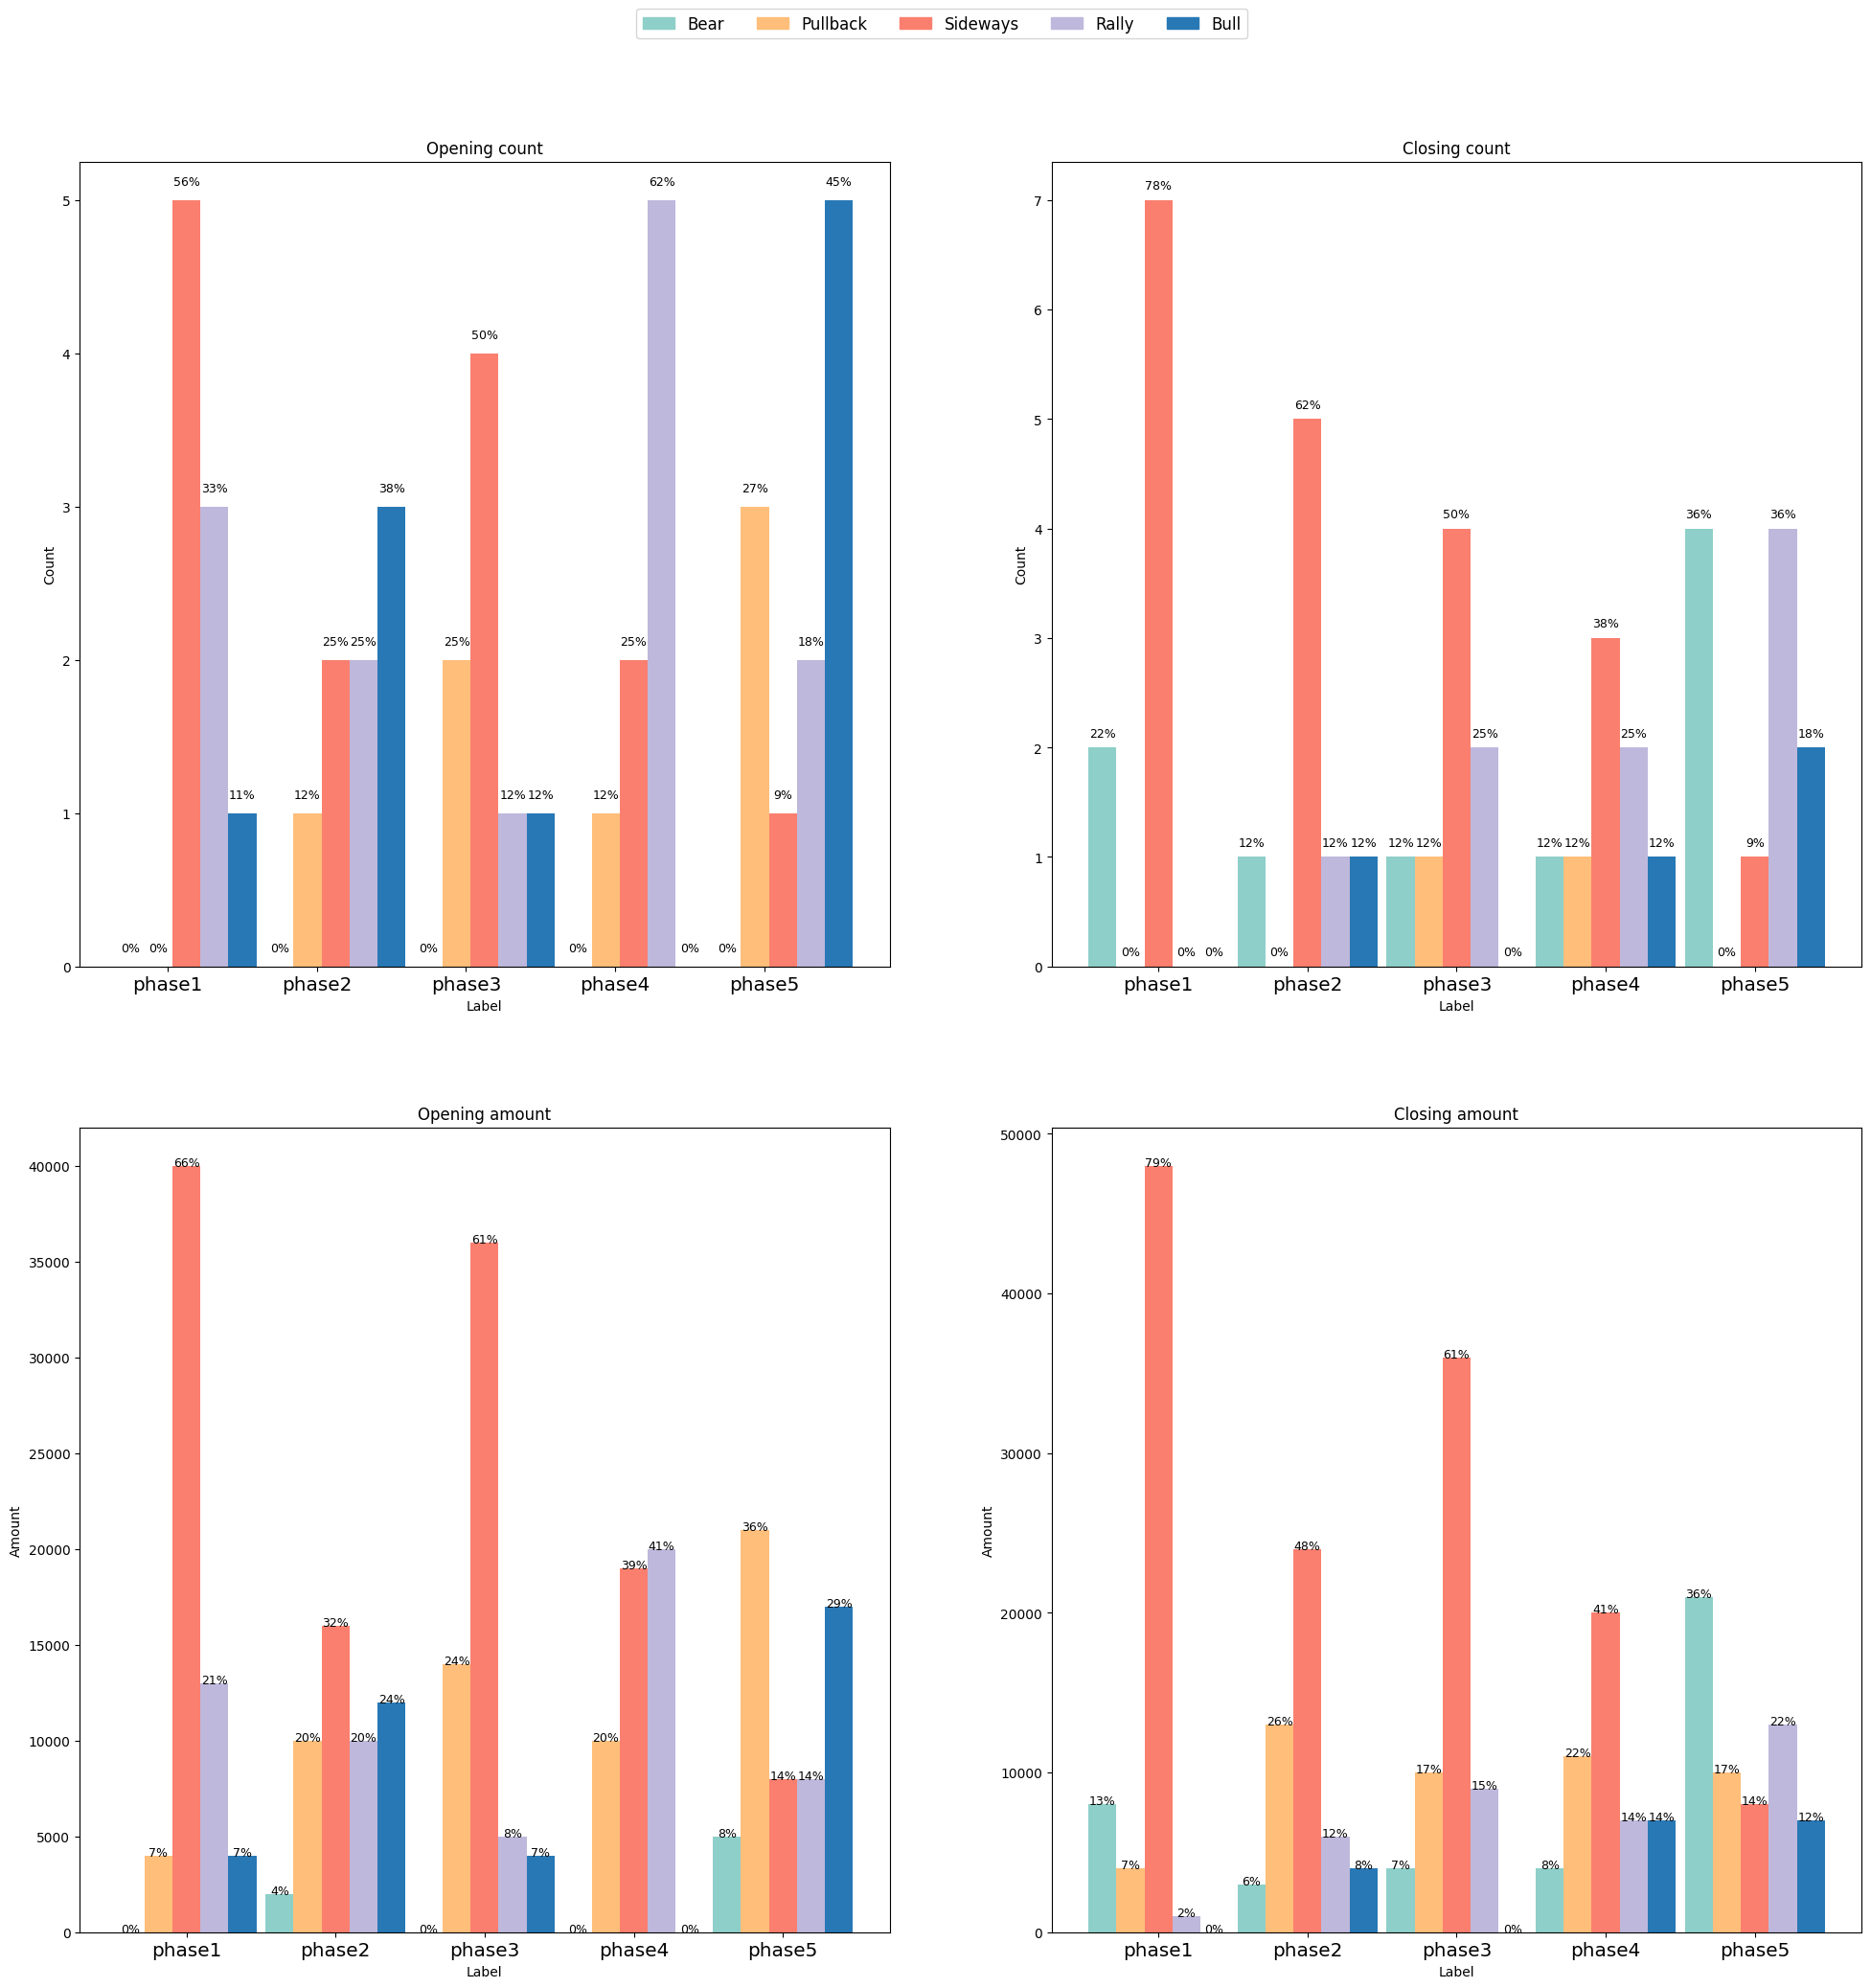

In [19]:
color_list = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#BEB8DC", "#2878B5"]
x_label = ["phase1","phase2","phase3","phase4","phase5"]
y_label = ["Bull", "Rally", "Sideways", "Pullback", "Bear"]
y_label.reverse()


x_ax = np.array(range(len(x_label)))*4

fig = plt.figure(figsize=(24,24))
# plt.suptitle('Opening/Closing counts/amounts along different time with diff market type')

patches = [
    mpatches.Patch(color=color_list[i], label="{:s}".format(y_label[i]))
    for i in range(len(color_list))
]

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height* 0.75])
fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=5, fontsize='large')

plt.subplot(221)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Opening count')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in opening_count_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(opening_count_seg)):
    plotdata=[count[i] for count in opening_count_seg]
    for x,y in enumerate(plotdata):
        plt.text(x*4+i*0.75, y+0.1,  format(opening_count_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)

plt.subplot(222)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Closing count')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in closing_count_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(closing_count_seg)):
    plotdata=[count[i] for count in closing_count_seg]
    for x,y in enumerate(plotdata):
        plt.text(x*4+i*0.75, y+0.1, format(closing_count_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)
        
plt.subplot(223)
plt.xlabel('Label')
plt.ylabel('Amount')
plt.title('Opening amount')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in opening_amount_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(opening_amount_seg)):
    plotdata=[count[i] for count in opening_amount_seg]
    for x,y in enumerate(plotdata):
        plt.text(x*4+i*0.75, y+0.1, format(opening_amount_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)
        
plt.subplot(224)
plt.xlabel('Label')
plt.ylabel('Amount')
plt.title('Closing amount')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in closing_amount_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(closing_amount_seg)):
    plotdata=[count[i] for count in closing_amount_seg]
    for x,y in enumerate(plotdata):
        plt.text(x*4+i*0.75, y+10, format(closing_amount_perc[x][i]*100,'.0f') + "%"  ,ha='center',fontsize=9)

img_path = path + "/time_dynamics_proportion.pdf"        
plt.savefig(img_path,bbox_inches='tight')
plt.show()

/tmp/ipykernel_2955417/2193936372.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


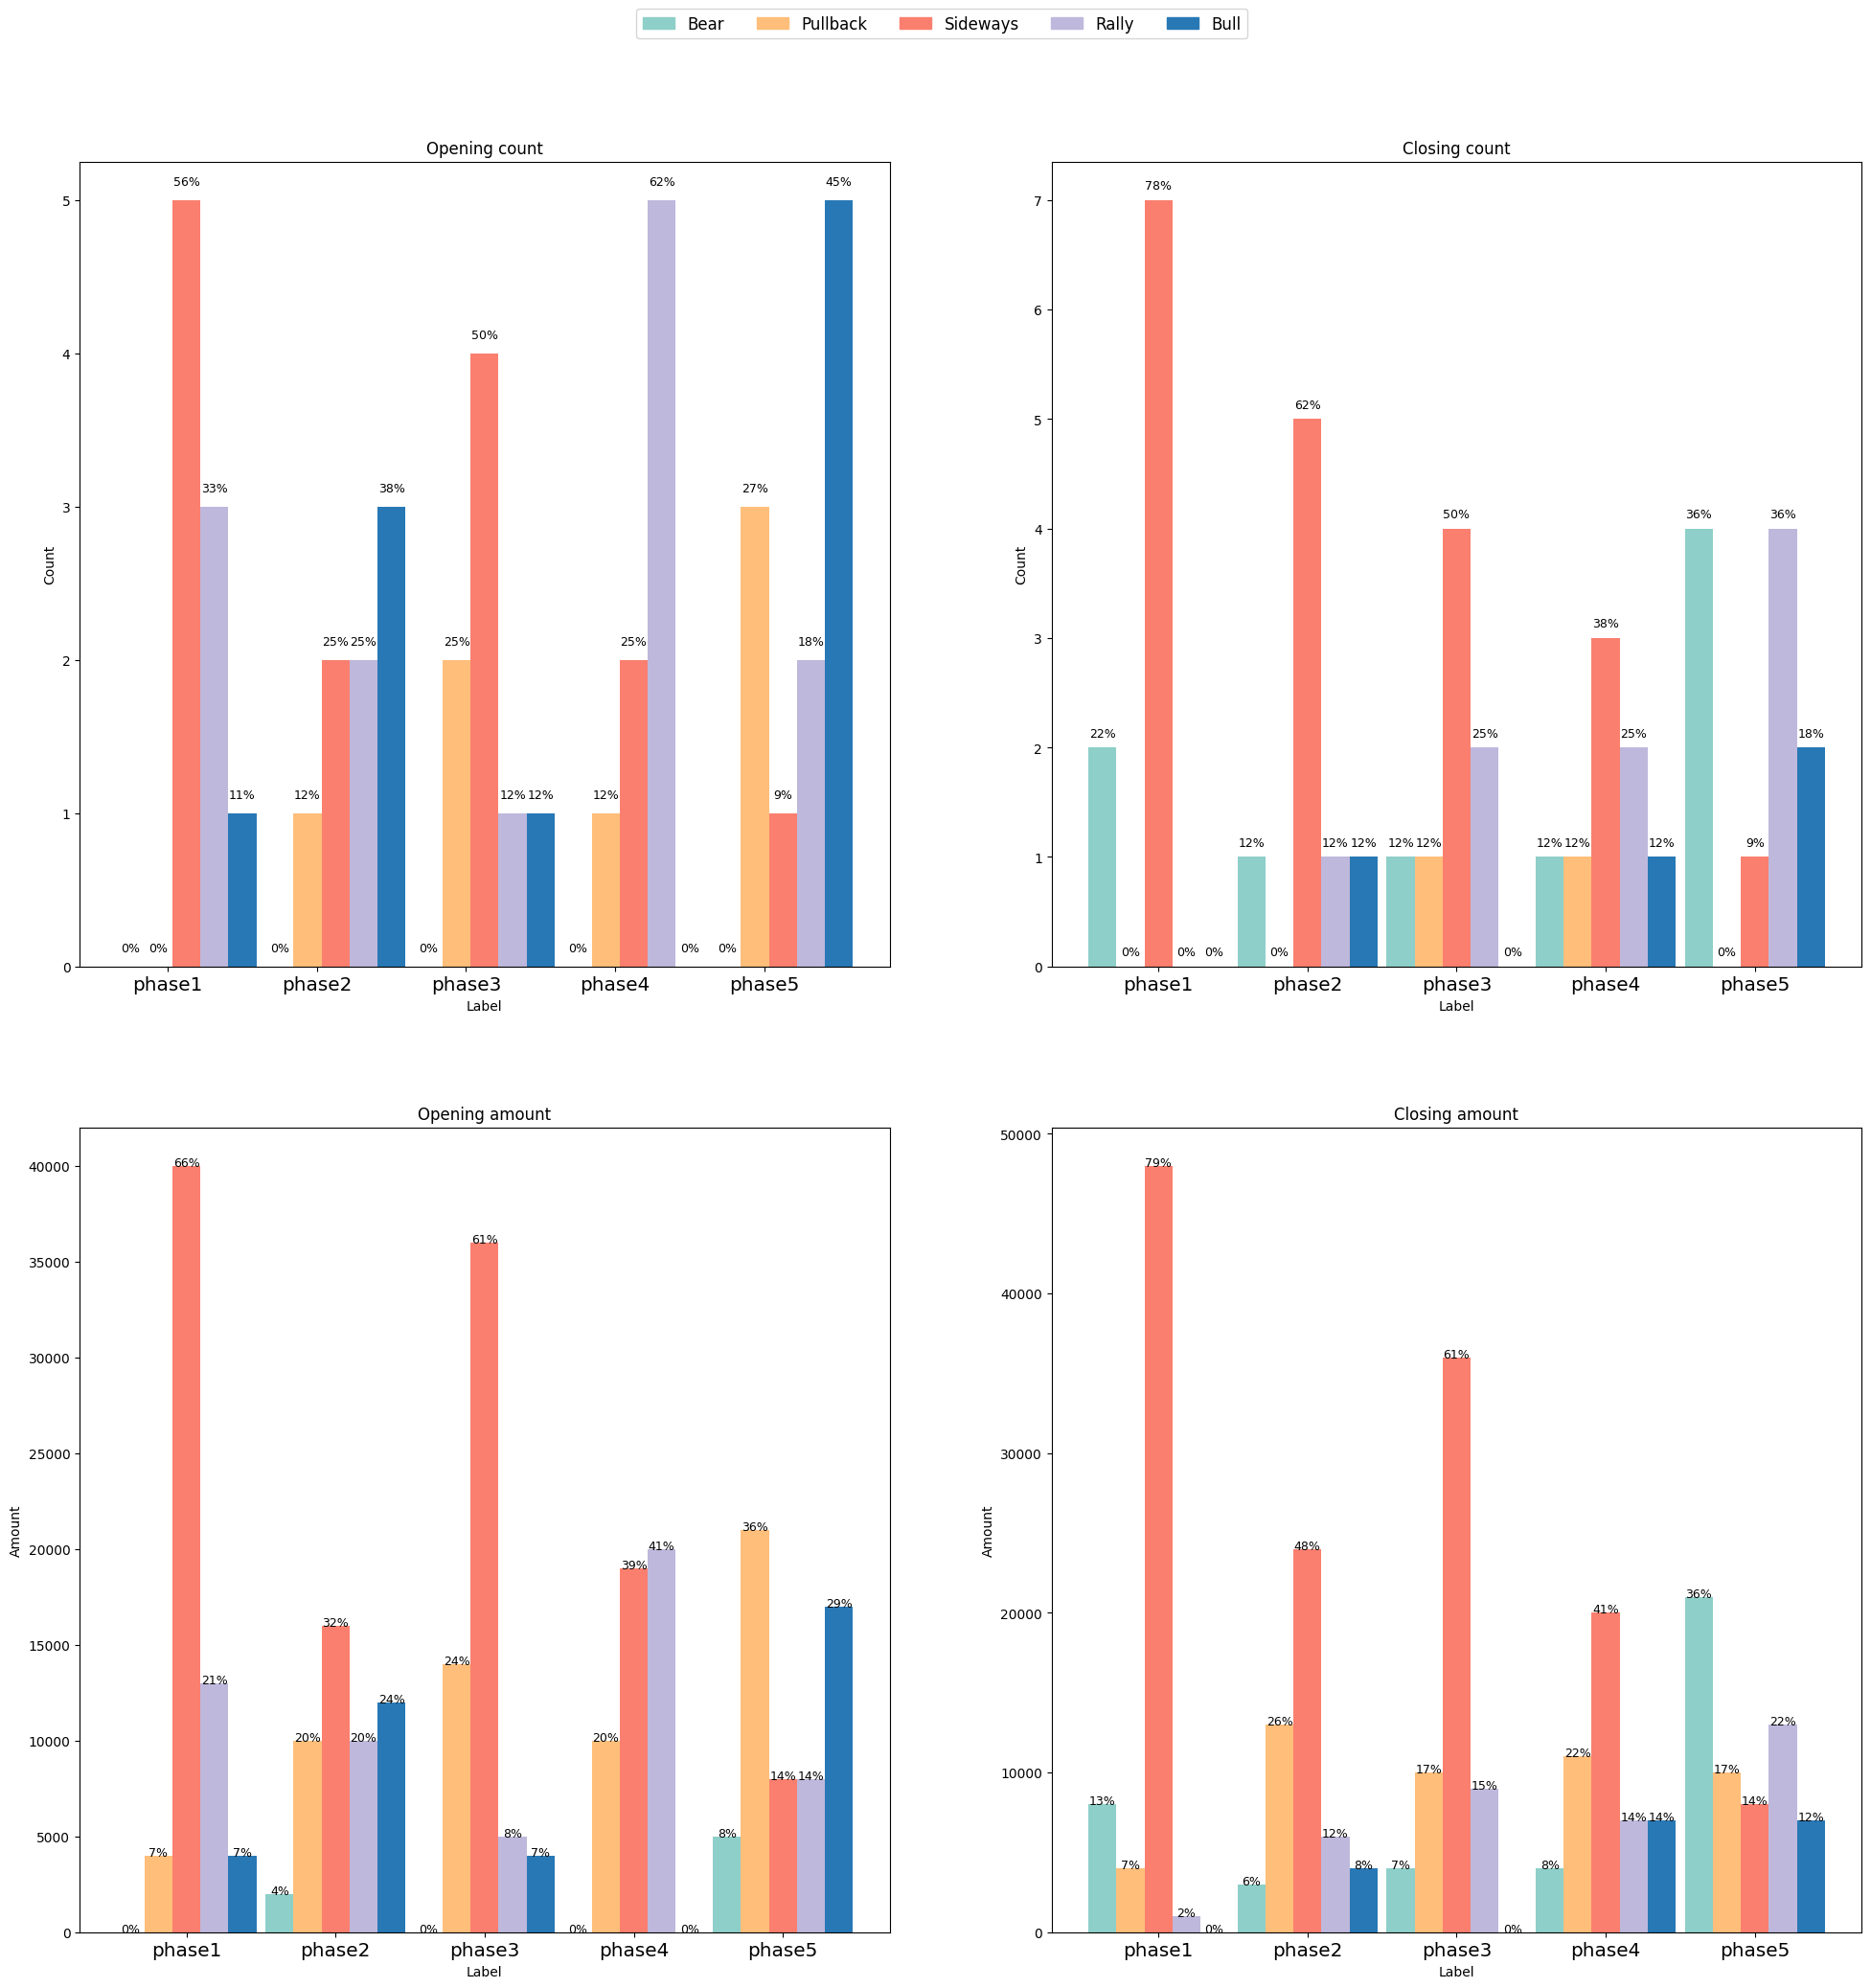

In [18]:
color_list = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#BEB8DC", "#2878B5"]
x_label = ["phase1","phase2","phase3","phase4","phase5"]
y_label = ["Bull", "Rally", "Sideways", "Pullback", "Bear"]
y_label.reverse()


x_ax = np.array(range(len(x_label)))*4

fig = plt.figure(figsize=(24,24))
# plt.suptitle('Opening/Closing counts/amounts along different time with diff market type')

patches = [
    mpatches.Patch(color=color_list[i], label="{:s}".format(y_label[i]))
    for i in range(len(color_list))
]

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height* 0.75])
fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=5, fontsize='large')

plt.subplot(221)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Opening count')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in opening_count_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(opening_count_seg)):
    data=[count[i] for count in opening_count_seg]
    for x,y in enumerate(data):
        plt.text(x*4+i*0.75, y+0.1,  format(opening_count_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)
 
plt.subplot(222)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Closing count')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in closing_count_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(closing_count_seg)):
    data=[count[i] for count in closing_count_seg]
    for x,y in enumerate(data):
        plt.text(x*4+i*0.75, y+0.1, format(closing_count_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)
        
plt.subplot(223)
plt.xlabel('Label')
plt.ylabel('Amount')
plt.title('Opening amount')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in opening_amount_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(opening_amount_seg)):
    data=[count[i] for count in opening_amount_seg]
    for x,y in enumerate(data):
        plt.text(x*4+i*0.75, y+0.1, format(opening_amount_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)
         
plt.subplot(224)
plt.xlabel('Label')
plt.ylabel('Amount')
plt.title('Closing amount')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in closing_amount_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(closing_amount_seg)):
    plotdata=[count[i] for count in closing_amount_seg]
    for x,y in enumerate(plotdata):
        plt.text(x*4+i*0.75, y+0.1, format(closing_amount_perc[x][i]*100,'.0f') + "%"  ,ha='center',fontsize=9)


img_path = path + "/time_dynamics_proportion.pdf"        
plt.savefig(img_path,bbox_inches='tight')
plt.show()

/tmp/ipykernel_2955417/1743596525.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


NameError: name 'opening_count_seg' is not defined

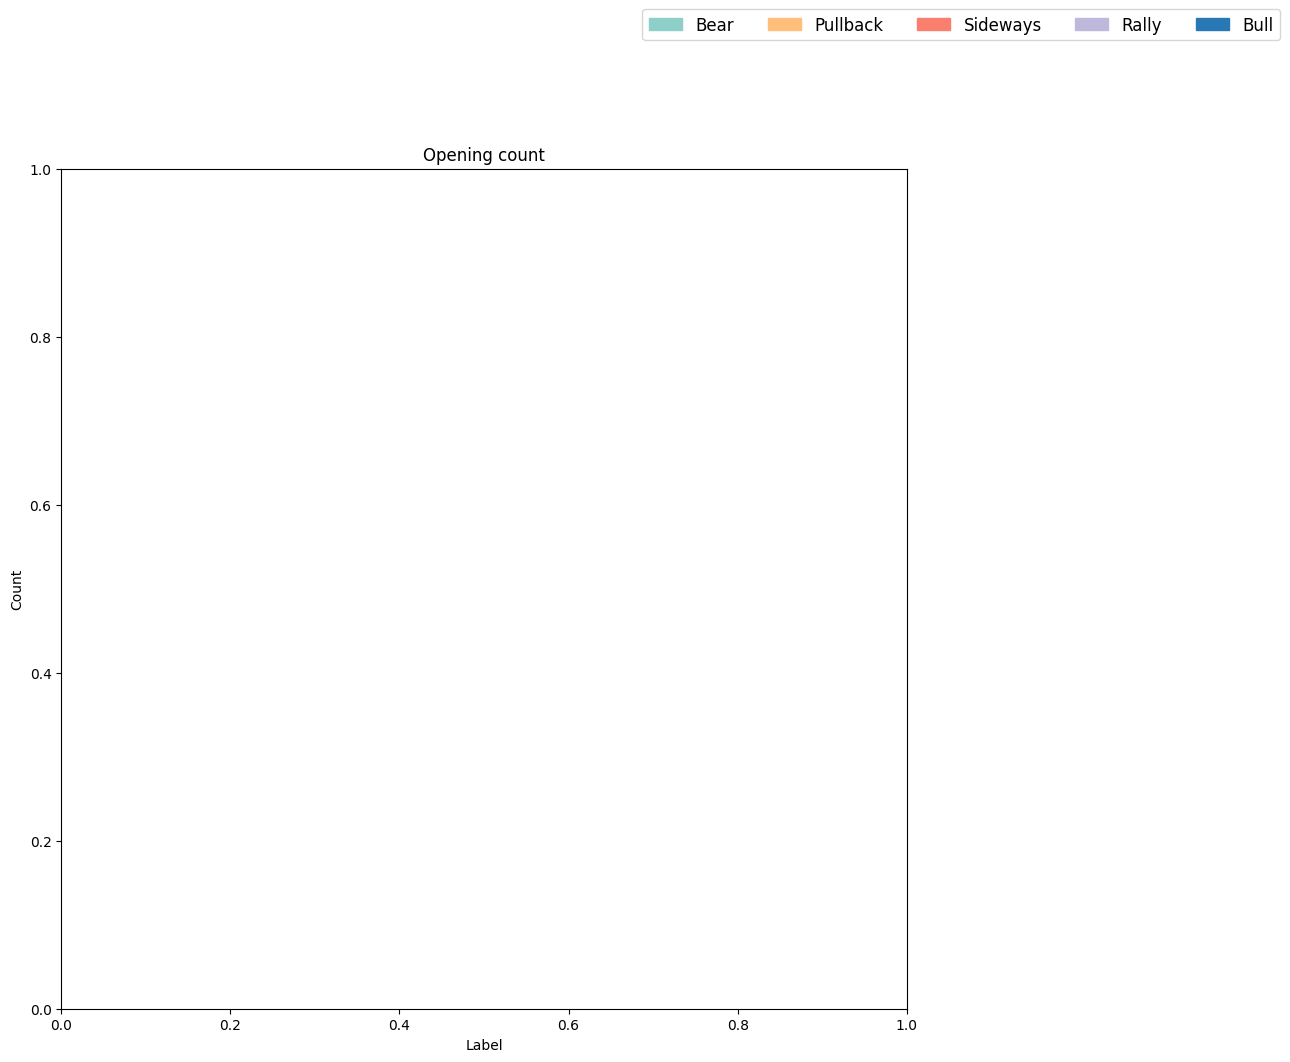

In [10]:
color_list = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#BEB8DC", "#2878B5"]
x_label = ["phase1", "phase2", "phase3", "phase4", "phase5"]
y_label = ["Bull", "Rally", "Sideways", "Pullback", "Bear"]
y_label.reverse()


x_ax = np.array(range(len(x_label))) * 4

fig = plt.figure(figsize=(24, 24))
# plt.suptitle('Opening/Closing counts/amounts along different time with diff market type')

patches = [
    mpatches.Patch(color=color_list[i], label="{:s}".format(y_label[i]))
    for i in range(len(color_list))
]

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height * 0.75])
fig.legend(
    handles=patches,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.95),
    ncol=5,
    fontsize="large",
)

plt.subplot(221)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Opening count")
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in opening_count_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(opening_count_seg)):
    for x, y in enumerate(data):
        plt.text(
            x * 4 + i * 0.75,
            y + 0.1,
            format(opening_count_perc[x][i] * 100, ".0f") + "%",
            ha="center",
            fontsize=9,
        )

plt.subplot(222)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Closing count")
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in closing_count_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(closing_count_seg)):
    for x, y in enumerate(data):
        plt.text(
            x * 4 + i * 0.75,
            y + 0.1,
            format(closing_count_perc[x][i] * 100, ".0f") + "%",
            ha="center",
            fontsize=9,
        )

plt.subplot(223)
plt.xlabel("Label")
plt.ylabel("Amount")
plt.title("Opening amount")
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in opening_amount_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(opening_amount_seg)):
    for x, y in enumerate(data):
        plt.text(
            x * 4 + i * 0.75,
            y + 0.1,
            format(opening_amount_perc[x][i] * 100, ".0f") + "%",
            ha="center",
            fontsize=9,
        )

plt.subplot(224)
plt.xlabel("Label")
plt.ylabel("Amount")
plt.title("Closing amount")
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in closing_amount_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(closing_amount_seg)):
    for x, y in enumerate(data):
        plt.text(
            x * 4 + i * 0.75,
            y + 5,
            format(closing_amount_perc[x][i] * 100, ".0f") + "%",
            ha="center",
            fontsize=9,
        )

# img_path = path + "/time_dynamics_proportion.pdf"
# plt.savefig(img_path,bbox_inches='tight')

plt.savefig("../data_test/market_trend_freq.pdf", bbox_inches="tight")
plt.show()

In [21]:
class Analyzer:
    def __init__(self, market_information, strategy):
        # market information should be a data frame that consist of 21 columns(timedstamp &  5-level ask bid's price and size)
        # stategy: a list of dictionary consisting of 3 keys: timestamp, action (buy or sell) and dictionary indicating the level
        # price and amount of the conducted orders
        self.market_information = market_information
        self.strategy = strategy
        # order in strategy[{'timestamp':,'action':,'order':[{'price':,'amount':},{'price':,'amount':},...],'position':}]
        # the strategy should be a list of market order containing the executed price, amount the agent's position after conducting the trade
        # check the pricing the problem
        price_timing = [price["timestamp"] for price in self.strategy]
        assert max(price_timing) <= max(self.market_information.timestamp)
        # check the price is legal
        for timestamp in self.market_information.timestamp.unique():
            price_single_timestamp = self.market_information[
                self.market_information["timestamp"] == timestamp
            ]

            assert (
                price_single_timestamp["ask1_price"].values[0]
                >= price_single_timestamp["bid1_price"].values[0]
            )
        # check the strategy opening position is whether is over rated and place correctly
        # 对于买单我们要检查他的买入价格的下限应该符合ask1 price
        for stack_order in strategy:
            timestamp = stack_order["timestamp"]
            current_market_information = self.market_information[
                self.market_information["timestamp"] == timestamp
            ]
            assert stack_order["action"] in ["buy", "sell"]
            if stack_order["action"] == "buy":
                list_order = stack_order["order"]
                level_number = len(list_order)
                for i in range(level_number):
                    assert (
                        list_order[i]["price"]
                        == current_market_information[
                            "ask{}_price".format(i + 1)
                        ].values[0]
                    )
                    assert (
                        list_order[i]["amount"]
                        <= current_market_information[
                            "ask{}_size".format(i + 1)
                        ].values[0]
                    )
            elif stack_order["action"] == "sell":
                list_order = stack_order["order"]
                level_number = len(list_order)
                for i in range(level_number):
                    assert (
                        list_order[i]["price"]
                        == current_market_information["bid{}_price".format(i)].values[0]
                    )
                    assert (
                        list_order[i]["amount"]
                        <= current_market_information["bid{}_size".format(i)].values[0]
                    )
        # check the trace of the position in the trading process is legal or not. it always should be 0 at the start and end of the trading process
        if self.strategy[-1]["position"] != 0:
            last_position = self.strategy[-1]["position"]
            warnings.warn(
                "the final position of the strategy is not zero, we force the agent to close its position in the last timestamp"
            )
            last_market_information = self.market_information[
                self.market_information["timestamp"]
                == max(self.market_information["timestamp"].unique())
            ]
            size_sum = 0
            if (
                last_position
                > last_market_information["bid1_size"].values[0]
                + last_market_information["bid2_size"].values[0]
                + last_market_information["bid3_size"].values[0]
                + last_market_information["bid4_size"].values[0]
                + last_market_information["bid5_size"].values[0]
            ):
                warnings.warn(
                    "we barely trade at this timstamp instantly because there is no enough liquidity in the market,\
                we force the agent to close its position in the last timestamp by expanding the last level's size"
                )
                last_market_information["bid5_size"] = last_position - (
                    last_market_information["bid1_size"].values[0]
                    + last_market_information["bid2_size"].values[0]
                    + last_market_information["bid3_size"].values[0]
                    + last_market_information["bid4_size"].values[0]
                )
            for i in range(5):
                size_sum += last_market_information["bid{}_size".format(i + 1)].values[
                    0
                ]
                if last_position <= size_sum:
                    break
            level_order_size_list = []
            order_remaining = last_position
            for j in range(i + 1):
                level_order_size_list.append(
                    {
                        "price": last_market_information[
                            "bid{}_price".format(j + 1)
                        ].values[0],
                        "amount": min(
                            order_remaining,
                            last_market_information["bid{}_size".format(j + 1)].values[
                                0
                            ],
                        ),
                    }
                )
                order_remaining = (
                    order_remaining
                    - last_market_information["bid{}_size".format(j + 1)].values[0]
                )
            self.strategy.append(
                {
                    "timestamp": last_market_information["timestamp"].values[0],
                    "action": "sell",
                    "order": level_order_size_list,
                    "position": 0,
                }
            )

    def analysis_behavior(self, selected_strategy):
        # 现确定总共的开闭仓的次数 selected strategy 起码开头和结尾的position应该为0
        opening_strategy_timestamp_list = []
        closing_strategy_timestamp_list = []

        for stack_order in selected_strategy:
            if stack_order["action"] == "buy":
                order_size = 0
                for order in stack_order["order"]:
                    order_size += order["amount"]
                if order_size == stack_order["position"]:
                    opening_strategy_timestamp_list.append(stack_order["timestamp"])
            elif stack_order["action"] == "sell":
                if stack_order["position"] == 0:
                    closing_strategy_timestamp_list.append(stack_order["timestamp"])
        assert len(opening_strategy_timestamp_list) == len(
            closing_strategy_timestamp_list
        )  # 确保开仓和平仓的次数相同
        trade_timestamp_list = list(
            zip(opening_strategy_timestamp_list, closing_strategy_timestamp_list)
        )

        # 1. 计算每次交易的收益率以及开仓到平仓的时间
        total_return_rate = 0
        total_duration = timedelta()
        total_mdd = 0

        for open_time, close_time in trade_timestamp_list:
            assert open_time < close_time
            single_trade_strategy = []
            for selected_stack_order in selected_strategy:
                if (
                    selected_stack_order["timestamp"] >= open_time
                    and selected_stack_order["timestamp"] <= close_time
                ):
                    single_trade_strategy.append(selected_stack_order)
            cash_flow = []
            print("single_trade_strategy", single_trade_strategy)
            # 计算每次交易的现金流的变化
            for stack_order in single_trade_strategy:
                print("stack_order", stack_order)
                total_value = 0
                for order in stack_order["order"]:
                    total_value += order["price"] * order["amount"]
                if stack_order["action"] == "buy":
                    total_value = -total_value
                cash_flow.append(total_value)
            cash_record = [sum(cash_flow[: i + 1]) for i in range(len(cash_flow))]
            final_cash = cash_record[-1]
            require_money = -min(cash_record)
            # 计算每次交易的收益率和持仓时间
            return_rate = final_cash / require_money
            total_return_rate += return_rate
            total_duration += close_time - open_time
            # TODO 根据bid1 price进行结算，每次持仓过程中的maxdrawdown
            position_record = []
            timestamp_record = []
            trade_position_record = []
            cash_accmulative_record = []
            for stack_order in single_trade_strategy:
                timestamp_record.append(stack_order["timestamp"])
                position_record.append(stack_order["position"])
            corresponding_market_timestamp = [
                timestamp
                for timestamp in self.market_information["timestamp"].unique()
                if timestamp >= open_time and timestamp <= close_time
            ]
            assert len(timestamp_record) == len(position_record)

            assert len(timestamp_record) == len(timestamp_record)  # 可删除
            for i in range(len(timestamp_record) - 1):
                time_point = [
                    timestamp
                    for timestamp in self.market_information["timestamp"].unique()
                    if timestamp >= timestamp_record[i]
                    and timestamp <= timestamp_record[i + 1]
                ]
                cash_accmulative_record.append(cash_record[i] + require_money)
                for j in range(len(time_point)):
                    trade_position_record.append(position_record[i])
                for k in range(len(time_point) - 1):
                    cash_accmulative_record.append(cash_accmulative_record[-1])
            # trade_position_record.append(0)
            corresponding_market_information = self.market_information[
                self.market_information["timestamp"].isin(
                    corresponding_market_timestamp
                )
            ]

            assert len(trade_position_record) == len(corresponding_market_information)

            position_value_record = [
                position * single_value
                for position, single_value in zip(
                    trade_position_record,
                    corresponding_market_information["bid1_price"].values,
                )
            ]
            total_value_record = [
                cash + position_value
                for cash, position_value in zip(
                    cash_accmulative_record, position_value_record
                )
            ]
            mdd = 0
            peak = total_value_record[0]
            for value in total_value_record:
                if value > peak:
                    peak = value
                dd = (peak - value) / peak
                if dd > mdd:
                    mdd = dd
            total_mdd += mdd

        mean_return_rate = total_return_rate / len(trade_timestamp_list)
        mean_duration = total_duration / len(trade_timestamp_list)
        mean_mdd = total_mdd / len(trade_timestamp_list)
        # TODO 你还需要计算这段策略中的胜率（trade中return rate大于0的数量/trade的总数量）
        return mean_return_rate, mean_duration, mean_mdd

    def calculate_metric(self, selected_timestamp: list):
        # selected trade is part of the strategy that we want to calculate the metric,
        # its position but do not have to end or start with 0
        # selected_timestamp is a 2-element list indicating the start and end of the timestamp
        selected_timestamp.sort()
        assert len(selected_timestamp) == 2
        selected_market = self.market_information[
            (self.market_information["timestamp"] >= selected_timestamp[0])
            & (self.market_information["timestamp"] <= selected_timestamp[1])
        ]
        selected_strategy = [
            item
            for item in self.strategy
            if selected_timestamp[0] <= item["timestamp"] <= selected_timestamp[1]
        ]
        first_trade = selected_strategy[0]
        first_trade_size = sum([level["amount"] for level in first_trade["order"]])
        if first_trade["action"] == "buy":
            first_trade_size = -first_trade_size

        initial_posotion = selected_strategy[0]["position"] + first_trade_size
        assert initial_posotion >= 0
        cash_flow = []
        for stack_order in selected_strategy:
            total_value = 0
            for order in stack_order["order"]:
                total_value += order["price"] * order["amount"]
                if stack_order["action"] == "buy":
                    total_value = -total_value
                cash_flow.append(total_value)
        initial_require_money = (
            initial_posotion * selected_market["bid1_price"].values[0]
        )
        cash_record = [sum(cash_flow[: i + 1]) for i in range(len(cash_flow))]
        require_money = initial_require_money - min(0, min(cash_record))
        position = initial_posotion
        position_market_record = []
        cash_market_record = []
        for timestamp in selected_market.timestamp.unique():
            matching_strategy = next(
                (item for item in selected_strategy if item["timestamp"] == timestamp),
                None,
            )
            if matching_strategy:
                current_position = matching_strategy["position"]
                position = current_position
            else:
                current_position = position
            position_market_record.append(current_position)
        inital_cash = require_money - initial_require_money
        cash = inital_cash
        for timestamp in selected_market.timestamp.unique():
            matching_strategy = next(
                (item for item in selected_strategy if item["timestamp"] == timestamp),
                None,
            )
            if matching_strategy:
                total_value = 0
                for order in matching_strategy["order"]:
                    total_value += order["price"] * order["amount"]
                    if stack_order["action"] == "buy":
                        total_value = -total_value
                current_cash = cash + total_value
                cash = current_cash
            else:
                current_cash = cash
            cash_market_record.append(current_cash)
        assert len(position_market_record) == len(selected_market)
        selected_market_price = selected_market["bid1_price"].values
        position_value_record = [
            position * single_value
            for position, single_value in zip(
                position_market_record, selected_market_price
            )
        ]
        total_value_record = [
            cash + position_value
            for cash, position_value in zip(cash_market_record, position_value_record)
        ]
        tr = total_value_record[-1] / total_value_record[0] - 1
        mdd = 0
        peak = total_value_record[0]
        for value in total_value_record:
            if value > peak:
                peak = value
            dd = (peak - value) / peak
            if dd > mdd:
                mdd = dd
        cr = tr / mdd
        return tr, mdd, cr

    def analysis_along_time(self, num_seg):
        opening_strategy_timestamp_list = []
        closing_strategy_timestamp_list = []

        for stack_order in self.strategy:
            if stack_order["action"] == "buy":
                order_size = 0
                for order in stack_order["order"]:
                    order_size += order["amount"]
                if order_size == stack_order["position"]:
                    opening_strategy_timestamp_list.append(stack_order["timestamp"])
            elif stack_order["action"] == "sell":
                if stack_order["position"] == 0:
                    closing_strategy_timestamp_list.append(stack_order["timestamp"])
        assert len(opening_strategy_timestamp_list) == len(
            closing_strategy_timestamp_list
        )
        print(len(opening_strategy_timestamp_list))

        assert len(opening_strategy_timestamp_list) >= num_seg
        num_trade_seg = int(len(opening_strategy_timestamp_list) / num_seg)
        for i in range(num_seg):
            if i != num_seg - 1:
                selected_timestamp = [
                    opening_strategy_timestamp_list[num_trade_seg * i],
                    closing_strategy_timestamp_list[num_trade_seg * (i + 1)],
                ]
                tr, mdd, cr = self.calculate_metric(selected_timestamp)

                print(
                    "in the {}th segment, the total return rate is {}, the max drawdown is {}, the calmar ratio is {}".format(
                        i, tr, mdd, cr
                    )
                )

            else:
                selected_timestamp = [
                    opening_strategy_timestamp_list[num_trade_seg * i],
                    closing_strategy_timestamp_list[-1],
                ]

                tr, mdd, cr = self.calculate_metric(selected_timestamp)
                print(
                    "in the {}th segment, the total return rate is {}, the max drawdown is {}, the calmar ratio is {}".format(
                        i, tr, mdd, cr
                    )
                )

    def analysis_along_dynamics(self, num_dynamics, elected_timestamp: list):
        # TODO 给定段时间，先把这段时间内的市场状态划分成num_dynamics个市场状态，找到这段时间对应的策略（通过comprehensive_evaluation/slice_model.py，
        # TODO 你可能需要修改最后一部分 使得他知道他对应timestamp的dynamics的label是什么即可）
        # TODO 然后计算每个市场状态下策略开仓次数占开仓总次数的多少百分比，平仓占平仓总次数的百分比
        # TODO 然后计算每个市场状态下策略开仓量占开仓总量的多少百分比，平仓量占平仓总量的百分比
        # TODO 思路 找strategy中对应的timestamp（应该相互吻合，然后根据这个timestamp找到对应的dynamics的 然后做统计）
        pass

    def analysis_along_time_dynamics(
        self, num_dynamics, num_seg, elected_timestamp: list
    ):
        # TODO 给定段时间，先把这段时间内的市场状态划分成num_dynamics个市场状态
        # TODO 根据策略 用开平仓的次数来划分时间（总开平仓次数）
        # TODO 两维度从时间和市场状态 计算胜率，收益率，持仓时间，最大回撤，calmar ratio，已经开仓量和平仓量占总开仓量和平仓量的百分比
        pass

In [22]:
analyzer = Analyzer(data, strategy)
time_analysis = analyzer.analysis_along_time(1)
mean_return_rate, mean_duration, mean_mdd = analyzer.analysis_behavior(
    analyzer.strategy
)
print("mean_return_rate", mean_return_rate)
print("mean_duration", mean_duration)
print("mean_mdd", mean_mdd)

KeyError: 'bid0_price'